In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('ggplot')

In [2]:
import sklearn
import matplotlib

print("scikit-learn version:", sklearn.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)

scikit-learn version: 1.6.1
pandas version: 2.2.3
numpy version: 2.2.4
matplotlib version: 3.10.1


### Data Preprocessing

In [3]:
df = pd.read_csv('data.csv')
# Replacing space with underscores on column
df.columns = df.columns.str.lower().str.replace(' ', '_')

# List contaning columns with type object
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

# Replacing space with underscoes for string/object columns within list 
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ','_')

In [4]:
df = df.astype({
    'transmission_type': 'category',
    'driven_wheels': 'category',
    'vehicle_size': 'category',
    'vehicle_style': 'category'
    })

In [5]:
# Get value counts for the 'make' column
make_value_counts = df['make'].value_counts()

# Convert the value counts into a new DataFrame
make_counts_df = make_value_counts.reset_index()

make_counts_df.head(10)

,make,count
0,chevrolet,1123
1,ford,881
2,volkswagen,809
3,toyota,746
4,dodge,626
5,nissan,558
6,gmc,515
7,honda,449
8,mazda,423
9,cadillac,397


In [6]:
# Segregate automobile brands based on their region of establishment
european_brands = ['volkswagen', 'mercedes-benz', 'bmw', 'audi', 'volvo', 'saab',
                  'land_rover', 'porsche', 'aston_martin', 'bentley', 'ferrari', 'fiat',
                  'maserati', 'lamborghini', 'rolls-royce', 'lotus', 'maybach',
                  'alfa_romeo', 'mclaren', 'spyker', 'bugatti']

us_brands = ['chevrolet', 'ford', 'dodge', 'gmc', 'cadillac', 'buick', 'chrysler',
            'pontiac', 'lincoln', 'oldsmobile', 'plymouth', 'hummer', 'tesla']

japanese_brands = ['toyota', 'nissan', 'honda', 'mazda', 'suzuki', 'infiniti',
                  'subaru', 'acura', 'kia', 'mitsubishi', 'lexus', 'hyundai', 'scion',
                  'genesis']

In [7]:
df[df['make'].isin(japanese_brands) & (df['year'] > 2000)].shape

(3916, 16)

In [8]:
print(f"""ratio of availability of japanese data released in 2000 and then to the entire sample 
      {df[df['make'].isin(japanese_brands) & (df['year'] > 2000)].shape[0]/df[df['make'].isin(japanese_brands)].shape[0]}""")

ratio of availability of japanese data released in 2000 and then to the entire sample 
      0.8946767192140735


In [9]:
dict(df.dtypes)

{'make': dtype('O'),
 'model': dtype('O'),
 'year': dtype('int64'),
 'engine_fuel_type': dtype('O'),
 'engine_hp': dtype('float64'),
 'engine_cylinders': dtype('float64'),
 'transmission_type': CategoricalDtype(categories=['automated_manual', 'automatic', 'direct_drive', 'manual',
                   'unknown'],
 , ordered=False, categories_dtype=object),
 'driven_wheels': CategoricalDtype(categories=['all_wheel_drive', 'four_wheel_drive', 'front_wheel_drive',
                   'rear_wheel_drive'],
 , ordered=False, categories_dtype=object),
 'number_of_doors': dtype('float64'),
 'market_category': dtype('O'),
 'vehicle_size': CategoricalDtype(categories=['compact', 'large', 'midsize'], ordered=False, categories_dtype=object),
 'vehicle_style': CategoricalDtype(categories=['2dr_hatchback', '2dr_suv', '4dr_hatchback', '4dr_suv',
                   'cargo_minivan', 'cargo_van', 'convertible',
                   'convertible_suv', 'coupe', 'crew_cab_pickup',
                   'extended_c

### Dataset splitting on car made in Japan

In [10]:
np.random.seed(12)

df_trunc = df[df['make'].isin(japanese_brands) & (df['year'] > 2000)]

n = len(df_trunc)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
## Take two portions out to make val and test compartments first
## So that the remaining part goes to training set
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

## Shuffle dataset respective to shuffled index
df_shuffled = df_trunc.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [11]:
y_train_orig = df_train.msrp.values
y_val_orig = df_val.msrp.values
y_test_orig = df_test.msrp.values

### Exploratory Data Analysis

In [12]:
def plot_correlation(df_train, df_origin, method, figsize, n_rows, n_cols):
    """
    Generate correlation mapping for visualizing the correlation 
    in both train and original datasets
    Argument:
        - df_train: training data
        - df_origin: original data
        - method: pearson or spearman
        - figsize: figure size-controlling config 
        - n_rows: # rows
        - n_cols: # columns
    Return:
        The matplotlib axes containing the plot
    """
    # Compute the correlation matrix
    df_corr_pear = df_train.corr(method=method)
    val_corr_pear = df_origin.corr(method=method)

    # Exclude duplicate values from the correlation matrix
    mask = np.triu(np.ones_like(df_corr_pear, dtype = bool))
    mask_orig = np.triu(np.ones_like(val_corr_pear, dtype = bool))

    # Set the figure size
    fig, axes = plt.subplots(n_rows, n_cols, figsize = figsize)

    # Set customized diverging palette
    if method == 'pearson':
        cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
    else:
        cmap = sns.diverging_palette(250, 400, s=120, as_cmap=True)
        
        
    # Create the heatmap
    sns.heatmap(df_corr_pear, annot=True, cmap=cmap, fmt = '.2f', center = 0, ax = axes[0], annot_kws = {'size': 12},
                mask = mask).set_title('Correlations Heatmap (in Train Dataset)')
    sns.heatmap(val_corr_pear, annot=True, cmap=cmap, fmt = '.2f', center = 0, ax = axes[1], annot_kws = {'size': 12},
                mask = mask_orig).set_title('Correlations Heatmap (in Validation Dataset)')

    # Show the plot
    plt.show()

In [13]:
num_cols = list(df.select_dtypes(include=['float64','int64']).columns)
cat_cols = list(df.select_dtypes(exclude=['float64','int64']).columns)
target_col = "msrp"

num_cols.remove(target_col)

In [14]:
df_train[num_cols+cat_cols+[target_col]].head()

,year,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity,make,model,engine_fuel_type,transmission_type,driven_wheels,market_category,vehicle_size,vehicle_style,msrp
10500,2016,290.0,6.0,4.0,31,21,204,acura,tlx,premium_unleaded_(recommended),automatic,all_wheel_drive,luxury,midsize,sedan,44800
5013,2017,261.0,6.0,4.0,21,16,2009,nissan,frontier,regular_unleaded,manual,four_wheel_drive,NaN,compact,crew_cab_pickup,29700
6789,2017,290.0,6.0,4.0,27,19,204,acura,mdx,premium_unleaded_(recommended),automatic,front_wheel_drive,"crossover,luxury",midsize,4dr_suv,50360
7293,2015,248.0,6.0,4.0,28,19,2202,honda,odyssey,regular_unleaded,automatic,front_wheel_drive,NaN,large,passenger_minivan,37775
8701,2009,232.0,NaN,4.0,22,16,586,mazda,rx-8,premium_unleaded_(required),manual,rear_wheel_drive,performance,compact,coupe,31000


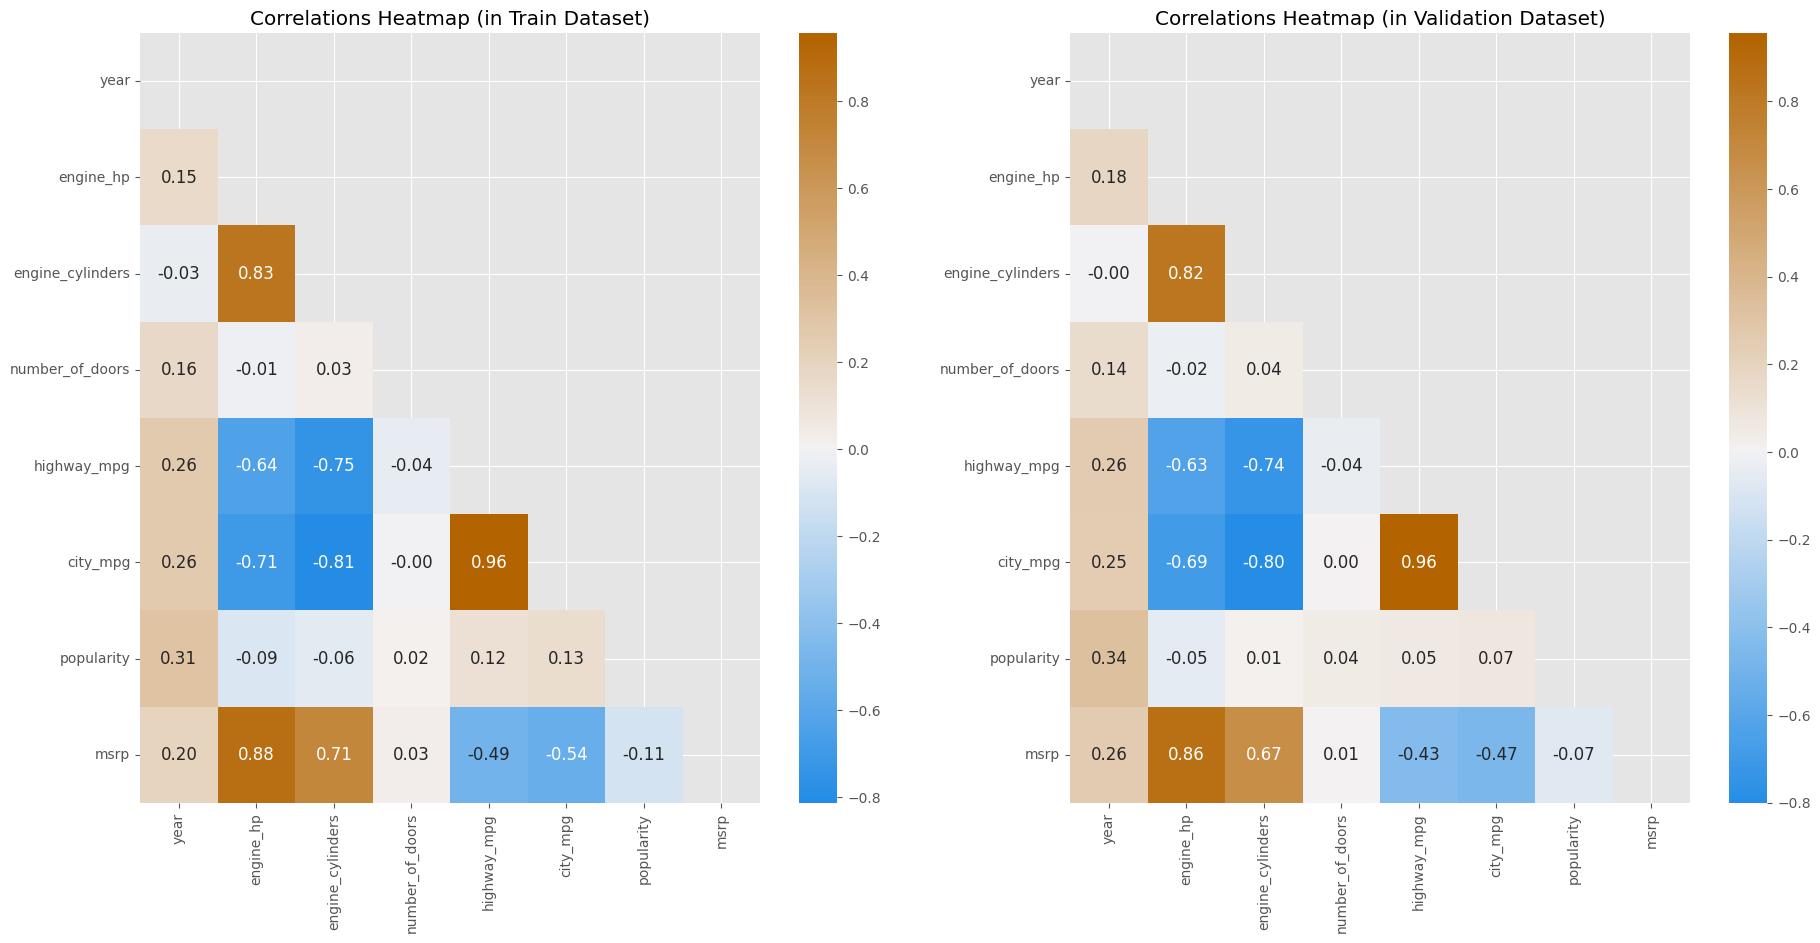

In [15]:
# Visualization config
n_rows, n_cols = 1, 2
figsize = (22, 10)

# Run pearson correlation for both `train_df` (train) and `original_df` (validation)
plot_correlation(
    df_train[num_cols+[target_col]], 
    df_val[num_cols+[target_col]], 
    'spearman', figsize, n_rows, n_cols
)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression

In [17]:
df_train_copy = df_train.copy()

# Encoding categorical and object variables
label_encoders = {}
for column in df_train_copy.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df_train_copy[column] = le.fit_transform(df_train_copy[column])
    label_encoders[column] = le

In [18]:
df_train_copy.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
10500,0,239,2016,3,290.0,6.0,1,0,4.0,30,2,11,31,21,204,44800
5013,9,73,2017,5,261.0,6.0,3,1,4.0,37,0,7,21,16,2009,29700
6789,0,150,2017,3,290.0,6.0,1,2,4.0,7,2,2,27,19,204,50360
7293,2,165,2015,5,248.0,6.0,1,2,4.0,37,1,9,28,19,2202,37775
8701,7,211,2009,4,232.0,NaN,3,3,4.0,36,0,6,22,16,586,31000


In [19]:
label_encoders.keys()

dict_keys(['make', 'model', 'engine_fuel_type', 'transmission_type', 'driven_wheels', 'market_category', 'vehicle_size', 'vehicle_style'])

In [20]:
# Calculate the correlation matrix for object and categorical variables
correlation_matrix = df_train_copy[['make', 'model', 'engine_fuel_type', 'transmission_type', 
                         'driven_wheels', 'market_category', 'vehicle_size', 'vehicle_style']].corr()

# Calculate mutual information scores for msrp with categorical and object variables
X = df_train_copy[['make', 'model', 'engine_fuel_type', 'transmission_type', 
                         'driven_wheels', 'market_category', 'vehicle_size', 'vehicle_style']]
mi_scores = mutual_info_regression(X, y_train_orig)

mi_scores = pd.Series(mi_scores, index=X.columns)


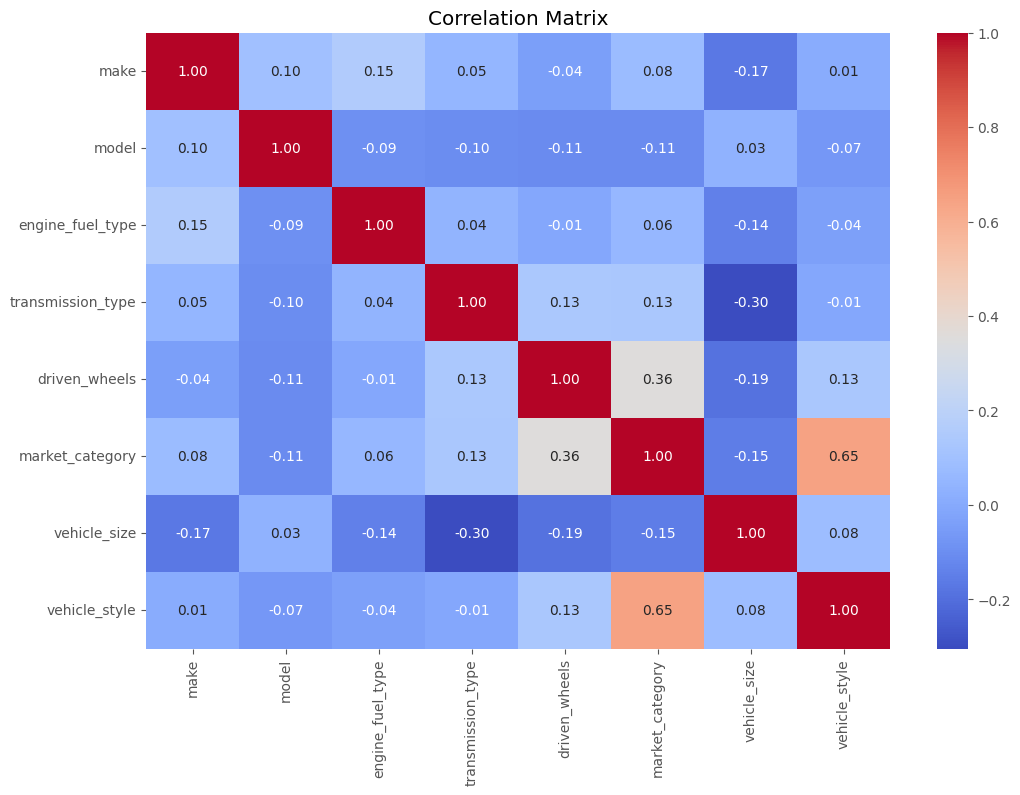

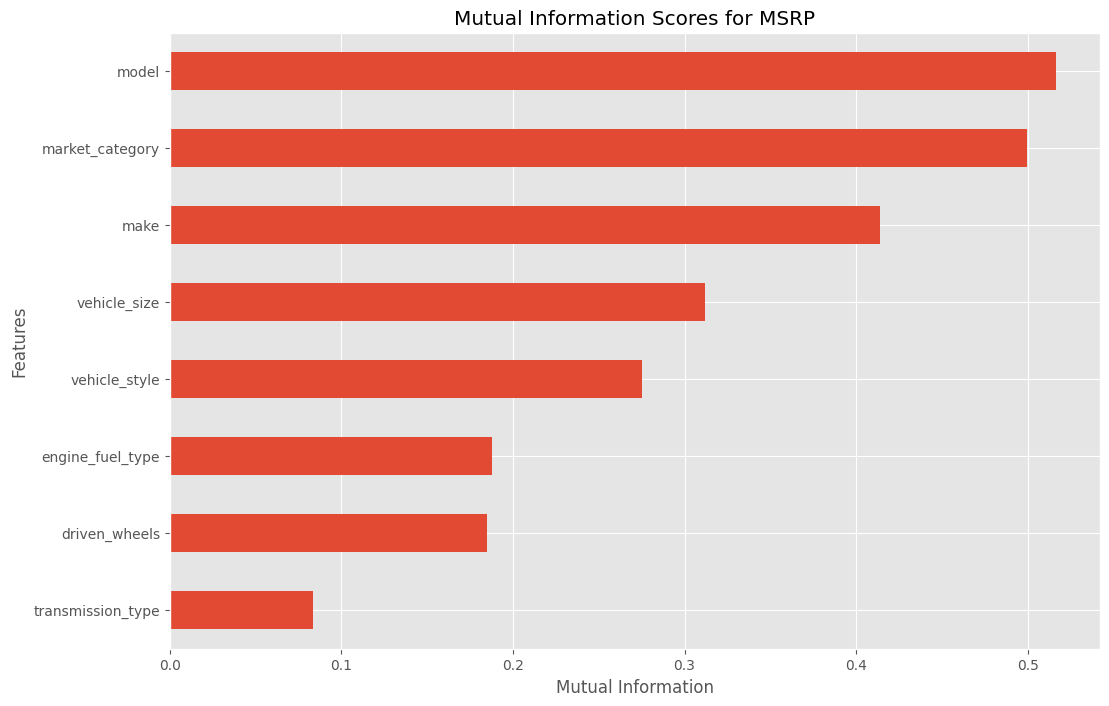

In [21]:
# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Plot mutual information scores
plt.figure(figsize=(12, 8))
mi_scores.sort_values().plot(kind='barh')
plt.title('Mutual Information Scores for MSRP')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.show()

In [22]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

### Using Statsmodels for Hypothesis Testing and Estimation the Coefficient and Standard Errors

In [35]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(strategy='median')
X_transfored = imp_mean.fit_transform(df_train_copy.drop(columns=['msrp']))

In [37]:
X_transformed = pd.DataFrame(X_transfored, columns=list(df_train_copy.drop(columns=['msrp']).columns))

# Dictionary specifying desired data types
data_types = {
    'make': 'int64',
    'model': 'int',
    'year': 'int64',
    'highway_mpg': 'int64',
    'city_mpg': 'int64',
    'popularity': 'int64'
}

# Convert data types according to the dictionary
X_transformed = X_transformed.astype(data_types)


In [38]:
import statsmodels.api as sm

# Fit the OLS regression model
X = X_transformed  # your predictor variables
y = y_train_orig  # your target variable
res = sm.OLS(y, X).fit()


In [39]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              2094.
Date:                Fri, 04 Apr 2025   Prob (F-statistic):                        0.00
Time:                        17:14:03   Log-Likelihood:                         -24736.
No. Observations:                2350   AIC:                                  4.950e+04
Df Residuals:                    2335   BIC:                                  4.959e+04
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
make               -302.6968     50.810     -5.957      0.000    -402.334    -203.060
model                -3.8017      2.304     -1.650      0.099      -8.319       0.716
year                  1.0974      1.503      0.730      0.465      -1.849       4.044
engine_fuel_type   1091.9668    271.094      4.028      0.000     560.358    1623.576
engine_hp           141.6454      4.962     28.545      0.000     131.915     151.376
engine_cylinders    727.3115    308.310      2.359      0.018     122.721    1331.902
transmission_type -1788.2429    258.235     -6.925      0.000   -2294.637   -1281.848
driven_wheels     -1004.4897    208.954     -4.807      0.000   -1414.244    -594.736
number_of_doors   -1422.6065    314.480     -4.524      0.000   -2039.295    -805.918
market_category     -30.3752     20.080     -1.513      0.130     -69.752       9.001
vehicle_size       -404.6378    237.688     -1.702      0.089    -870.740      61.465
vehicle_style        33.3107     67.741      0.492      0.623     -99.528     166.149
highway_mpg        -167.1200     85.246     -1.960      0.050    -334.285       0.045
city_mpg            414.7148     66.132      6.271      0.000     285.031     544.398
popularity           -2.5671      0.260     -9.859      0.000      -3.078      -2.057
==============================================================================
Omnibus:                     4632.758   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20920409.773
Skew:                          15.029   Prob(JB):                         0.00
Kurtosis:                     464.250   Cond. No.                     4.45e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Perform hypothesis testing on a specific coefficient
coefficient_name = 'engine_hp'
p_value = model.waldtest([coefficient_name], use_f=True)[1]

print(f"P-value for {coefficient_name}: {p_value:.4f}")

# Estimate the coefficients and standard errors
coefficients = model.params
standard_errors = model.bse

print("Estimated Coefficients:")
for coefficient, std_error in zip(coefficients, standard_errors):
    print(f"{coefficient:.4f} ± {std_error:.4f}")

### Inspecting Feature Contribution with Permutation-based Feature Importance

A technique named `Permutation feature importance`  is used to estimate the contribution of each feature to a fitted model's statistical performance on a given tabular dataset. This approach runs random shuffling the values of a single feature while also separates the association of the features and the target. Thus, it gives us a reliable way to observe model's reliance on particular features and how much its performance drops over these features. With its model-agnostic capability, any model can receive its benefit from permutation feature importance.

In [41]:
from sklearn.inspection import permutation_importance


def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

In [42]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2350 entries, 10500 to 387
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   make               2350 non-null   object  
 1   model              2350 non-null   object  
 2   year               2350 non-null   int64   
 3   engine_fuel_type   2348 non-null   object  
 4   engine_hp          2341 non-null   float64 
 5   engine_cylinders   2338 non-null   float64 
 6   transmission_type  2350 non-null   category
 7   driven_wheels      2350 non-null   category
 8   number_of_doors    2350 non-null   float64 
 9   market_category    1553 non-null   object  
 10  vehicle_size       2350 non-null   category
 11  vehicle_style      2350 non-null   category
 12  highway_mpg        2350 non-null   int64   
 13  city_mpg           2350 non-null   int64   
 14  popularity         2350 non-null   int64   
dtypes: category(4), float64(3), int64(4), object(4)
memory us

In [43]:
# Define the threshold for unique values
threshold = 20

# Identify categorical columns with more than 5 unique values
columns_to_drop = [col for col in df_train.select_dtypes(include=['category','object']) if df_train[col].nunique() > threshold]
columns_to_drop

['model', 'market_category']

In [44]:
list(filter(lambda i: i not in columns_to_drop, list(df_train.select_dtypes(include=['category','object']).columns)))

['make',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'vehicle_size',
 'vehicle_style']

#### Data Pipeline

To easily putting together many and different processing logics into a single, larger pipeline, `compose` and `pipeline` functions are the best option to put into the table.

In [46]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.imputation import CategoricalImputer

categorical_columns = list(filter(lambda i: i not in columns_to_drop, list(df_train.select_dtypes(include=['category','object']).columns)))
numerical_columns = list(df_train.select_dtypes(include=['float64','int64']).columns)

cat_pipeline = make_pipeline(
            CategoricalImputer(imputation_method='frequent', variables=categorical_columns),
            CountFrequencyEncoder(
                variables=categorical_columns,
                ignore_format=True  # Ensure variables are not changed to other formats
            ))

preprocessor = make_column_transformer(
    (SimpleImputer(strategy='median'), numerical_columns),
    (cat_pipeline, categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

In [47]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('simpleimputer',
                                 SimpleImputer(strategy='median'),
                                 ['year', 'engine_hp', 'engine_cylinders',
                                  'number_of_doors', 'highway_mpg', 'city_mpg',
                                  'popularity']),
                                ('pipeline',
                                 Pipeline(steps=[('categoricalimputer',
                                                  CategoricalImputer(imputation_method='frequent',
                                                                     variables=['make',
                                                                                'engine_fuel_type',
                                                                                'transmissio...
                                                                                'driven_wheels',
                                                                                'vehicle_size',
                                                                                'vehicle_style'])),
                                                 ('countfrequencyencoder',
                                                  CountFrequencyEncoder(ignore_format=True,
                                                                        variables=['make',
                                                                                   'engine_fuel_type',
                                                                                   'transmission_type',
                                                                                   'driven_wheels',
                                                                                   'vehicle_size',
                                                                                   'vehicle_style']))]),
                                 ['make', 'engine_fuel_type',
                                  'transmission_type', 'driven_wheels',
                                  'vehicle_size', 'vehicle_style'])],
                  verbose_feature_names_out=False)

Now, the complete steps of transformation stage are ready to work. We will see how the training set undergoes changes with fit and transform methods.

In [48]:
# Fit and transform the training set using the preprocessor
transformed_data = preprocessor.fit_transform(df_train)

# Get the column names after transformation
transformed_columns = preprocessor.get_feature_names_out()

# Create a new DataFrame with the transformed data
transformed_df_train = pd.DataFrame(transformed_data, columns=transformed_columns)

In [49]:
preprocessor.get_feature_names_out(df_train.columns)

array(['year', 'engine_hp', 'engine_cylinders', 'number_of_doors',
       'highway_mpg', 'city_mpg', 'popularity', 'make',
       'engine_fuel_type', 'transmission_type', 'driven_wheels',
       'vehicle_size', 'vehicle_style', 'model', 'market_category'],
      dtype=object)

#### Fitting the Random Forest with Pipeline

Now that we have prepared a transformation pipeline, it's about the time for building a composite estimator. It is common that transformers (not to be confused with attention-based transformer) are oftenly combined with regressors or classifiers. 

In [50]:
from sklearn.compose import TransformedTargetRegressor
from  sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
import scipy as sp

rf_model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RandomForestRegressor(min_samples_split=3, max_features="log2"), 
        func=np.log10, inverse_func=sp.special.exp10
    ),
)

In [51]:
preprocessor

D:\github_repos\mlzoomcamp\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('simpleimputer',
                                 SimpleImputer(strategy='median'),
                                 ['year', 'engine_hp', 'engine_cylinders',
                                  'number_of_doors', 'highway_mpg', 'city_mpg',
                                  'popularity']),
                                ('pipeline',
                                 Pipeline(steps=[('categoricalimputer',
                                                  CategoricalImputer(imputation_method='frequent',
                                                                     variables=['make',
                                                                                'engine_fuel_type',
                                                                                'transmissio...
                                                                                'driven_wheels',
                                                                                'vehicle_size',
                                                                                'vehicle_style'])),
                                                 ('countfrequencyencoder',
                                                  CountFrequencyEncoder(ignore_format=True,
                                                                        variables=['make',
                                                                                   'engine_fuel_type',
                                                                                   'transmission_type',
                                                                                   'driven_wheels',
                                                                                   'vehicle_size',
                                                                                   'vehicle_style']))]),
                                 ['make', 'engine_fuel_type',
                                  'transmission_type', 'driven_wheels',
                                  'vehicle_size', 'vehicle_style'])],
                  verbose_feature_names_out=False)

In [52]:
df_train = df_train.drop(columns_to_drop, axis=1)
df_train.isna().sum()

make                  0
year                  0
engine_fuel_type      2
engine_hp             9
engine_cylinders     12
transmission_type     0
driven_wheels         0
number_of_doors       0
vehicle_size          0
vehicle_style         0
highway_mpg           0
city_mpg              0
popularity            0
dtype: int64

In [53]:
rf_model.fit(df_train, y_train_orig)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['year', 'engine_hp',
                                                   'engine_cylinders',
                                                   'number_of_doors',
                                                   'highway_mpg', 'city_mpg',
                                                   'popularity']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('categoricalimputer',
                                                                   CategoricalImputer(imputation_method='frequent',
                                                                                      variables=['...
                                                                                                    'driven_wheels',
                                                                                                    'vehicle_size',
                                                                                                    'vehicle_style']))]),
                                                  ['make', 'engine_fuel_type',
                                                   'transmission_type',
                                                   'driven_wheels',
                                                   'vehicle_size',
                                                   'vehicle_style'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RandomForestRegressor(max_features='log2',
                                                                            min_samples_split=3)))])

In [54]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

df_val = df_val.drop(columns_to_drop, axis=1)
df_test = df_test.drop(columns_to_drop, axis=1)

In [55]:
mae_train = median_absolute_error(y_train_orig, rf_model.predict(df_train))
mae_val = median_absolute_error(y_val_orig, rf_model.predict(df_val))
mae_test = median_absolute_error(y_test_orig, rf_model.predict(df_test))

scores = {
    "MedAE on training set": f"{mae_train:.2f}",
    "MedAE on validation set": f"{mae_val:.2f}",
    "MedAE on testing set": f"{mae_test:.2f}",
}

In [56]:
y_pred = rf_model.predict(df_test)
y_pred_val = rf_model.predict(df_val)

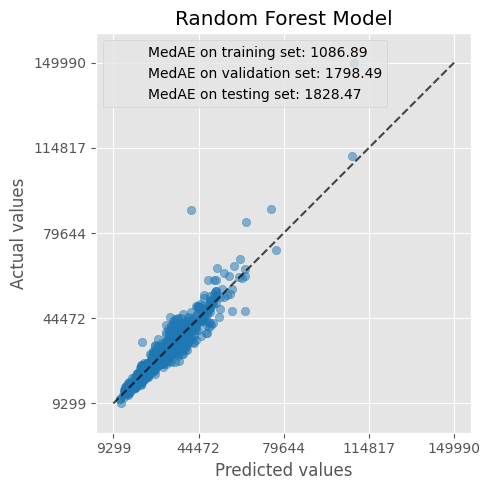

In [57]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_val_orig, y_pred_val, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Random Forest Model")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

In [58]:
# Create a dictionary to store data
data_prepared = {
        'df_train': df_train, 'df_val': df_val, 'df_test': df_test,
        'y_train_orig': y_train_orig, 'y_val_orig': y_val_orig, 'y_test_orig': y_test_orig
        }

### Inference Testing on Model fitted on Japan to the European made car

How about cars made from europe? Can this method apply?

In [59]:
np.random.seed(12)

df_trunc = df[df['make'].isin(european_brands) & (df['year'] > 2000)]

n = len(df_trunc)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
## Take two portions out to make val and test compartments first
## So that the remaining part goes to training set
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

## Shuffle dataset respective to shuffled index
df_shuffled = df_trunc.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [60]:
y_train_orig = df_train.msrp.values
y_val_orig = df_val.msrp.values
y_test_orig = df_test.msrp.values

In [61]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

In [62]:
df_train = df_train.drop(columns_to_drop, axis=1)
df_val = df_val.drop(columns_to_drop, axis=1)
df_test = df_test.drop(columns_to_drop, axis=1)

In [63]:
y_pred = rf_model.predict(df_test)
y_pred_val = rf_model.predict(df_val)

D:\github_repos\mlzoomcamp\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:260: UserWarning: During the encoding, NaN values were introduced in the feature(s) make, engine_fuel_type.
  warnings.warn(
D:\github_repos\mlzoomcamp\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:260: UserWarning: During the encoding, NaN values were introduced in the feature(s) make, engine_fuel_type.
  warnings.warn(


In [64]:
mae_train = median_absolute_error(y_train_orig, rf_model.predict(df_train))
mae_val = median_absolute_error(y_val_orig, rf_model.predict(df_val))
mae_test = median_absolute_error(y_test_orig, rf_model.predict(df_test))

scores = {
    "MedAE on training set": f"{mae_train:.2f}",
    "MedAE on validation set": f"{mae_val:.2f}",
    "MedAE on testing set": f"{mae_test:.2f}",
}

D:\github_repos\mlzoomcamp\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:260: UserWarning: During the encoding, NaN values were introduced in the feature(s) make, engine_fuel_type.
  warnings.warn(
D:\github_repos\mlzoomcamp\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:260: UserWarning: During the encoding, NaN values were introduced in the feature(s) make, engine_fuel_type.
  warnings.warn(
D:\github_repos\mlzoomcamp\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:260: UserWarning: During the encoding, NaN values were introduced in the feature(s) make, engine_fuel_type.
  warnings.warn(


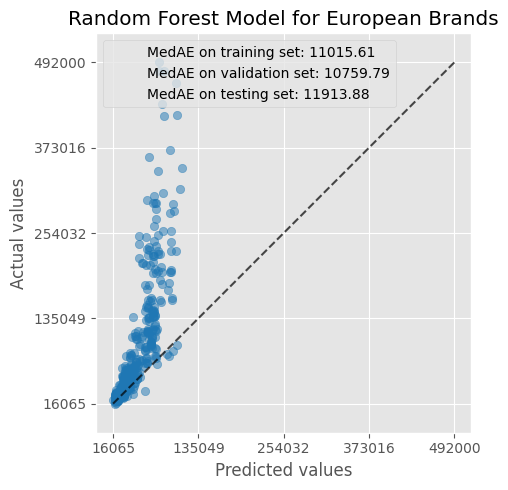

In [65]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_val_orig, y_pred_val, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Random Forest Model for European Brands")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

The model trained on automobiles produced in Japan is far from satisfactory when the regression makes the inference on european counterpart, that our assumption that the same distribution between both can lead to the model being relevant. Let's see how far the deviation that all data has. In that case, making the new model is a compulsory. 

In [66]:
### Building model pipeline for Europe from ground
rf_eu_model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RandomForestRegressor(min_samples_split=3, max_features="log2"), 
        func=np.log10, inverse_func=sp.special.exp10
    ),
)

In [67]:
rf_eu_model.fit(df_train, y_train_orig)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['year', 'engine_hp',
                                                   'engine_cylinders',
                                                   'number_of_doors',
                                                   'highway_mpg', 'city_mpg',
                                                   'popularity']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('categoricalimputer',
                                                                   CategoricalImputer(imputation_method='frequent',
                                                                                      variables=['...
                                                                                                    'driven_wheels',
                                                                                                    'vehicle_size',
                                                                                                    'vehicle_style']))]),
                                                  ['make', 'engine_fuel_type',
                                                   'transmission_type',
                                                   'driven_wheels',
                                                   'vehicle_size',
                                                   'vehicle_style'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RandomForestRegressor(max_features='log2',
                                                                            min_samples_split=3)))])

In [68]:
y_pred = rf_eu_model.predict(df_test)
y_pred_val = rf_eu_model.predict(df_val)

In [69]:
mae_train = median_absolute_error(y_train_orig, rf_eu_model.predict(df_train))
mae_val = median_absolute_error(y_val_orig, rf_eu_model.predict(df_val))
mae_test = median_absolute_error(y_test_orig, rf_eu_model.predict(df_test))

scores = {
    "MedAE on training set": f"{mae_train:.2f}",
    "MedAE on validation set": f"{mae_val:.2f}",
    "MedAE on testing set": f"{mae_test:.2f}",
}

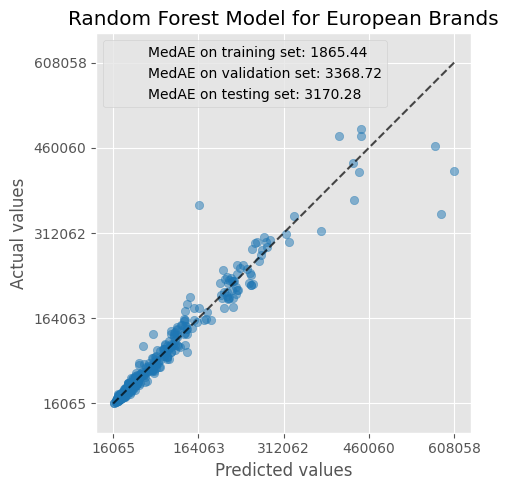

In [70]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_val_orig, y_pred_val, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Random Forest Model for European Brands")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

Now, the model looks much better in fit itself against european car group. Interestingly, few predictions ware far off the regression line and we do the sanity check which information that the regression could not infer the price with accuracy.

### Testing Predictive Capabilities

In [71]:
# Define the criterion (e.g., greater than 400,000)
criterion = y_pred_val > 400000

# Use the boolean mask to filter the y_pred_val
filtered_array = y_pred_val[criterion]
indices = np.where(criterion)[0]

In [72]:
all(filtered_array == y_pred_val[indices])

True

In [73]:
df_val_reset = df_val.reset_index(drop=True)
df_val_reset = df_val_reset.drop(index=list(indices), axis=0)

In [74]:
### Showing rows which their predictions were far off the line
df_val.iloc[indices].reset_index()

,index,make,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
0,617,maybach,2012,premium_unleaded_(required),620.0,12.0,automatic,rear_wheel_drive,4.0,large,sedan,16,10,67
1,7563,rolls-royce,2016,premium_unleaded_(required),453.0,12.0,automatic,rear_wheel_drive,4.0,large,sedan,19,11,86
2,7553,rolls-royce,2014,premium_unleaded_(required),453.0,12.0,automatic,rear_wheel_drive,2.0,large,coupe,19,11,86
3,7562,rolls-royce,2015,premium_unleaded_(required),453.0,12.0,automatic,rear_wheel_drive,4.0,large,sedan,19,11,86
4,700,maybach,2011,premium_unleaded_(required),620.0,12.0,automatic,rear_wheel_drive,4.0,large,sedan,16,10,67
5,7056,lamborghini,2008,premium_unleaded_(required),632.0,12.0,manual,all_wheel_drive,2.0,compact,convertible,13,8,1158
6,7057,lamborghini,2008,premium_unleaded_(required),632.0,12.0,automated_manual,all_wheel_drive,2.0,compact,coupe,14,9,1158
7,7558,rolls-royce,2016,premium_unleaded_(required),453.0,12.0,automatic,rear_wheel_drive,2.0,large,convertible,19,11,86
8,7557,rolls-royce,2015,premium_unleaded_(required),453.0,12.0,automatic,rear_wheel_drive,2.0,large,convertible,19,11,86


In [75]:
# Filter out rows from df_vals that matches with indeces
df_val_no_extreme = df_val_reset.copy()

y_pred_val_no_extreme = rf_eu_model.predict(df_val_no_extreme)

# Exclude rows from the array using np.delete
y_val_orig_no_extreme = np.delete(y_val_orig, indices)

median_absolute_error(y_val_orig_no_extreme, y_pred_val_no_extreme)

np.float64(3295.93970286124)

In [76]:
data_prepared.keys()

dict_keys(['df_train', 'df_val', 'df_test', 'y_train_orig', 'y_val_orig', 'y_test_orig'])

### Save Preprocessor and two Random Forest Models

In [78]:
from joblib import dump, load

dump(preprocessor, 'object_binary/preprocessor.joblib')

['object_binary/preprocessor.joblib']

In [79]:
dump(rf_model, 'object_binary/rf_model.joblib')

['object_binary/rf_model.joblib']

In [80]:
dump(rf_eu_model, 'object_binary/eu_model.joblib')

['object_binary/eu_model.joblib']

### Store All Features and Target in HDFStore format

To better manages all processed data into a single object store, pandas has a way to save the DataFrame or Series objects directly into an object with lesser disk space and faster retireve. HDF5 format is capable of storing heterogeneous data objects in hierarchical manners. Every HDF file starts with a root group('/') that contains other groups and/or data objects.

In [ ]:
store = pd.HDFStore("store_jap_region.h5", 'w')  
store.put('/features/train', data_prepared['df_train'], format="table")  

In [105]:
store.put('/features/val', data_prepared['df_val'], format="table")
store.put('/features/test', data_prepared['df_test'], format="table")  

In [106]:
store.put('/target/y_train_orig', pd.Series(data_prepared['y_train_orig']), format="table")

In [107]:
store.put('/target/y_val_orig', pd.Series(data_prepared['y_val_orig']), format="table")
store.put('/target/y_test_orig', pd.Series(data_prepared['y_test_orig']), format="table")

In [108]:
print(store.groups())

[/target/y_test_orig (Group) ''
  children := ['table' (Table)], /target/y_train_orig (Group) ''
  children := ['table' (Table)], /target/y_val_orig (Group) ''
  children := ['table' (Table)], /features/test (Group) ''
  children := ['meta' (Group), 'table' (Table)], /features/train (Group) ''
  children := ['meta' (Group), 'table' (Table)], /features/val (Group) ''
  children := ['meta' (Group), 'table' (Table)], /features/val/meta/values_block_3/meta (Group) ''
  children := ['table' (Table)], /features/val/meta/values_block_2/meta (Group) ''
  children := ['table' (Table)], /features/val/meta/values_block_1/meta (Group) ''
  children := ['table' (Table)], /features/val/meta/values_block_0/meta (Group) ''
  children := ['table' (Table)], /features/train/meta/values_block_3/meta (Group) ''
  children := ['table' (Table)], /features/train/meta/values_block_2/meta (Group) ''
  children := ['table' (Table)], /features/train/meta/values_block_1/meta (Group) ''
  children := ['table' (Tabl

In [109]:
store.close()

For preprocessor and a trained random forest fitted on data of Japan, we will use binary object storage named joblib.